<a href="https://colab.research.google.com/github/DavutcanJ/CreatingCarImagesWithGAN/blob/main/ysaproje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Will generate 96px square images.
Looking for file: /content/drive/MyDrive/YsaImages/riotu-cars-dataset-200/bmw/bmw-series5/bmw-series5-gen-2011-2016/training_data_96_96.npy
Loading previous training pickle...
tf.Tensor([[0.50039005]], shape=(1, 1), dtype=float32)
Epoch 1, gen loss=1.2776086330413818,disc loss=1.376053810119629, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 126ms/step
Epoch 2, gen loss=1.5348113775253296,disc loss=0.9256212115287781, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 30ms/step
Epoch 3, gen loss=1.8134204149246216,disc loss=0.8991915583610535, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 26ms/step
Epoch 4, gen loss=1.8584965467453003,disc loss=0.8457881212234497, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 24ms/step
Epoch 5, gen loss=

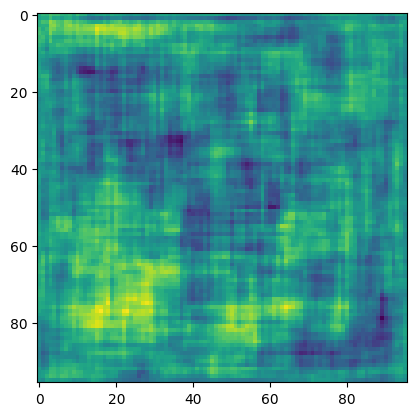

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import time
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
drive.mount('/content/drive')

GENERATE_RES = 3 # Generation resolution factor
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 150

# Configuration
DATA_PATH = '/content/drive/MyDrive/YsaImages/Par1'
EPOCHS = 200
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH)
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image=cv2.imread(path)
      image=cv2.resize(image,(GENERATE_SQUARE, GENERATE_SQUARE))
      training_data.append(image)
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

#shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape,
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

def save_images(cnt,noise):
  image_array = np.full((
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)),
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3),
      255, dtype=np.uint8)

  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1


  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_accuracy(real_output, fake_output):
    # Gerçek ve sahte çıkışları sigmoid aktivasyon fonksiyonuyla [0, 1] aralığına getirme
    real_predictions = tf.round(tf.sigmoid(real_output))
    fake_predictions = tf.round(tf.sigmoid(fake_output))

    # Doğruluk hesaplama
    correct_real_predictions = tf.equal(real_predictions, tf.ones_like(real_predictions))
    correct_fake_predictions = tf.equal(fake_predictions, tf.zeros_like(fake_predictions))

    # Toplam doğru tahmin sayısı
    total_correct = tf.reduce_sum(tf.cast(correct_real_predictions, tf.float32)) + tf.reduce_sum(tf.cast(correct_fake_predictions, tf.float32))

    # Toplam örnek sayısı
    total_samples = tf.cast(tf.size(real_output), tf.float32)

    # Doğruluk oranı
    accuracy = total_correct / total_samples

    return accuracy

generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)


    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator,
        discriminator.trainable_variables))
  return gen_loss,disc_loss

def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS,
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           ' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

train(train_dataset, EPOCHS)

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import time
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
drive.mount('/content/drive')

GENERATE_RES = 3 # Generation resolution factor
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 150

# Configuration
#DATA_PATH = '/content/drive/Othercomputers/David/dataset'
DATA_PATH = '/content/drive/MyDrive/YsaImages/Part2'
EPOCHS = 200
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")








Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Will generate 96px square images.
Looking for file: /content/drive/MyDrive/YsaImages/Part2/training_data_96_96.npy


In [11]:
if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH)
  for filename in tqdm(os.listdir(faces_path)):
    print(filename)
    path = os.path.join(faces_path, filename)

    # Dosyanın varlığını kontrol et
    if os.path.exists(path):
        # Görüntüyü oku
        image = cv2.imread(path)

        # Görüntüyü başarıyla okunduysa devam et
        if image is not None:
            # Görüntüyü yeniden boyutlandır
            image = cv2.resize(image, (GENERATE_SQUARE, GENERATE_SQUARE))

            # Yeniden boyutlandırılmış görüntüyü ekle
            training_data.append(image)
        else:
            print(f"Uyarı: {path} dosyası okunamadı. Bir sonraki döngüye geçiliyor.")
            continue
    else:
        print(f"Hata: {path} dosyası bulunamadı.")
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

#shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Loading training images...


  0%|          | 0/971 [00:00<?, ?it/s]

toyota-prado-gen-1996-2002-185.jpg


  0%|          | 1/971 [00:00<06:45,  2.39it/s]

toyota-prado-gen-1996-2002-186.jpg


  0%|          | 2/971 [00:00<06:52,  2.35it/s]

toyota-prado-gen-1996-2002-166.jpg


  0%|          | 4/971 [00:01<05:26,  2.96it/s]

toyota-prado-gen-1996-2002-167.jpg
toyota-prado-gen-1996-2002-179.jpg


  1%|          | 5/971 [00:01<04:39,  3.46it/s]

toyota-prado-gen-1996-2002-181.jpg


  1%|          | 7/971 [00:02<03:38,  4.41it/s]

toyota-prado-gen-1996-2002-177.jpg
toyota-prado-gen-1996-2002-191.jpg


  1%|          | 8/971 [00:02<05:31,  2.91it/s]

toyota-prado-gen-1996-2002-183.jpg


  1%|          | 9/971 [00:03<05:55,  2.71it/s]

toyota-prado-gen-1996-2002-190.jpg


  1%|          | 10/971 [00:05<17:22,  1.08s/it]

toyota-prado-gen-1996-2002-188.jpg


  2%|▏         | 24/971 [00:10<05:02,  3.13it/s]

toyota-prado-gen-1996-2002-178.jpg
toyota-prado-gen-1996-2002-175.jpg
toyota-prado-gen-1996-2002-189.jpg
toyota-prado-gen-1996-2002-168.jpg
toyota-prado-gen-1996-2002-170.jpg
toyota-prado-gen-1996-2002-180.jpg
toyota-prado-gen-1996-2002-182.jpg
toyota-prado-gen-1996-2002-171.jpg
toyota-prado-gen-1996-2002-165.jpg
toyota-prado-gen-1996-2002-172.jpg
toyota-prado-gen-1996-2002-169.jpg
toyota-prado-gen-1996-2002-174.jpg
toyota-prado-gen-1996-2002-176.jpg
toyota-prado-gen-1996-2002-173.jpg
toyota-prado-gen-1996-2002-184.jpg
toyota-prado-gen-1996-2002-187.jpg
toyota-prado-gen-1996-2002-196.jpg
toyota-prado-gen-1996-2002-201.jpg
toyota-prado-gen-2003-2020-105.jpg
toyota-prado-gen-1996-2002-215.jpg
toyota-prado-gen-1996-2002-217.jpg
toyota-prado-gen-1996-2002-195.jpg
toyota-prado-gen-1996-2002-199.jpg


  5%|▍         | 44/971 [00:10<01:38,  9.46it/s]

toyota-prado-gen-1996-2002-222.jpg
toyota-prado-gen-2003-2020-109.jpg
toyota-prado-gen-1996-2002-220.jpg
toyota-prado-gen-1996-2002-194.jpg
toyota-prado-gen-1996-2002-212.jpg
toyota-prado-gen-1996-2002-221.jpg
toyota-prado-gen-1996-2002-208.jpg
toyota-prado-gen-1996-2002-206.jpg
toyota-prado-gen-1996-2002-228.jpg
toyota-prado-gen-2003-2020-1.jpg
toyota-prado-gen-1996-2002-218.jpg
toyota-prado-gen-1996-2002-223.jpg
toyota-prado-gen-1996-2002-205.jpg
toyota-prado-gen-1996-2002-197.jpg
toyota-prado-gen-2003-2020-100.jpg
toyota-prado-gen-1996-2002-210.jpg
toyota-prado-gen-1996-2002-219.jpg
toyota-prado-gen-2003-2020-101.jpg


  6%|▋         | 62/971 [00:10<00:47, 19.09it/s]

toyota-prado-gen-1996-2002-226.jpg
toyota-prado-gen-1996-2002-230.jpg
toyota-prado-gen-2003-2020-10.jpg
toyota-prado-gen-1996-2002-203.jpg
toyota-prado-gen-1996-2002-224.jpg
toyota-prado-gen-1996-2002-204.jpg
toyota-prado-gen-2003-2020-103.jpg
toyota-prado-gen-2003-2020-102.jpg
toyota-prado-gen-1996-2002-214.jpg
toyota-prado-gen-1996-2002-193.jpg
toyota-prado-gen-1996-2002-207.jpg
toyota-prado-gen-1996-2002-225.jpg
toyota-prado-gen-1996-2002-213.jpg
toyota-prado-gen-1996-2002-229.jpg
toyota-prado-gen-1996-2002-192.jpg
toyota-prado-gen-1996-2002-216.jpg
toyota-prado-gen-2003-2020-108.jpg
toyota-prado-gen-1996-2002-209.jpg
toyota-prado-gen-1996-2002-200.jpg
toyota-prado-gen-2003-2020-104.jpg
toyota-prado-gen-2003-2020-107.jpg


  9%|▊         | 83/971 [00:11<00:29, 29.83it/s]

toyota-prado-gen-1996-2002-227.jpg
toyota-prado-gen-2003-2020-106.jpg
toyota-prado-gen-1996-2002-211.jpg
toyota-prado-gen-1996-2002-202.jpg
toyota-prado-gen-1996-2002-198.jpg
toyota-prado-gen-2003-2020-128.jpg
toyota-prado-gen-2003-2020-17.jpg
toyota-prado-gen-2003-2020-187.jpg
toyota-prado-gen-2003-2020-207.jpg
toyota-prado-gen-2003-2020-149.jpg
toyota-prado-gen-2003-2020-110.jpg
toyota-prado-gen-2003-2020-125.jpg
toyota-prado-gen-2003-2020-184.jpg
toyota-prado-gen-2003-2020-174.jpg
toyota-prado-gen-2003-2020-12.jpg
toyota-prado-gen-2003-2020-151.jpg
toyota-prado-gen-2003-2020-152.jpg


 10%|█         | 99/971 [00:11<00:22, 39.22it/s]

toyota-prado-gen-2003-2020-168.jpg
toyota-prado-gen-2003-2020-198.jpg
toyota-prado-gen-2003-2020-192.jpg
toyota-prado-gen-2003-2020-203.jpg
toyota-prado-gen-2003-2020-127.jpg
toyota-prado-gen-2003-2020-134.jpg
toyota-prado-gen-2003-2020-15.jpg
toyota-prado-gen-2003-2020-190.jpg
toyota-prado-gen-2003-2020-14.jpg
toyota-prado-gen-2003-2020-185.jpg
toyota-prado-gen-2003-2020-182.jpg


 12%|█▏        | 114/971 [00:11<00:18, 47.60it/s]

toyota-prado-gen-2003-2020-195.jpg
toyota-prado-gen-2003-2020-210.jpg
toyota-prado-gen-2003-2020-164.jpg
toyota-prado-gen-2003-2020-204.jpg
toyota-prado-gen-2003-2020-117.jpg
toyota-prado-gen-2003-2020-165.jpg
toyota-prado-gen-2003-2020-178.jpg
toyota-prado-gen-2003-2020-197.jpg
toyota-prado-gen-2003-2020-129.jpg
toyota-prado-gen-2003-2020-140.jpg
toyota-prado-gen-2003-2020-191.jpg
toyota-prado-gen-2003-2020-112.jpg
toyota-prado-gen-2003-2020-171.jpg


 12%|█▏        | 121/971 [00:11<00:16, 51.38it/s]

toyota-prado-gen-2003-2020-205.jpg
toyota-prado-gen-2003-2020-137.jpg
toyota-prado-gen-2003-2020-113.jpg
toyota-prado-gen-2003-2020-173.jpg
toyota-prado-gen-2003-2020-120.jpg
toyota-prado-gen-2003-2020-13.jpg
toyota-prado-gen-2003-2020-206.jpg
toyota-prado-gen-2003-2020-159.jpg
toyota-prado-gen-2003-2020-138.jpg
toyota-prado-gen-2003-2020-194.jpg
toyota-prado-gen-2003-2020-212.jpg
toyota-prado-gen-2003-2020-145.jpg
toyota-prado-gen-2003-2020-163.jpg


 14%|█▍        | 139/971 [00:12<00:13, 61.01it/s]

toyota-prado-gen-2003-2020-160.jpg
toyota-prado-gen-2003-2020-186.jpg
toyota-prado-gen-2003-2020-166.jpg
toyota-prado-gen-2003-2020-18.jpg
toyota-prado-gen-2003-2020-148.jpg
toyota-prado-gen-2003-2020-141.jpg
toyota-prado-gen-2003-2020-189.jpg
toyota-prado-gen-2003-2020-123.jpg
toyota-prado-gen-2003-2020-179.jpg
toyota-prado-gen-2003-2020-199.jpg
toyota-prado-gen-2003-2020-11.jpg
toyota-prado-gen-2003-2020-175.jpg
toyota-prado-gen-2003-2020-132.jpg
toyota-prado-gen-2003-2020-200.jpg
toyota-prado-gen-2003-2020-150.jpg
toyota-prado-gen-2003-2020-209.jpg
toyota-prado-gen-2003-2020-146.jpg
toyota-prado-gen-2003-2020-139.jpg
toyota-prado-gen-2003-2020-119.jpg
toyota-prado-gen-2003-2020-162.jpg


 16%|█▋        | 160/971 [00:12<00:11, 73.21it/s]

toyota-prado-gen-2003-2020-114.jpg
toyota-prado-gen-2003-2020-131.jpg
toyota-prado-gen-2003-2020-157.jpg
toyota-prado-gen-2003-2020-111.jpg
toyota-prado-gen-2003-2020-154.jpg
toyota-prado-gen-2003-2020-143.jpg
toyota-prado-gen-2003-2020-183.jpg
toyota-prado-gen-2003-2020-161.jpg
toyota-prado-gen-2003-2020-167.jpg
toyota-prado-gen-2003-2020-208.jpg
toyota-prado-gen-2003-2020-201.jpg
toyota-prado-gen-2003-2020-115.jpg
toyota-prado-gen-2003-2020-142.jpg
toyota-prado-gen-2003-2020-176.jpg
toyota-prado-gen-2003-2020-158.jpg
toyota-prado-gen-2003-2020-196.jpg
toyota-prado-gen-2003-2020-177.jpg
toyota-prado-gen-2003-2020-21.jpg
toyota-prado-gen-2003-2020-156.jpg


 18%|█▊        | 177/971 [00:12<00:11, 71.50it/s]

toyota-prado-gen-2003-2020-202.jpg
toyota-prado-gen-2003-2020-193.jpg
toyota-prado-gen-2003-2020-19.jpg
toyota-prado-gen-2003-2020-16.jpg
toyota-prado-gen-2003-2020-181.jpg
toyota-prado-gen-2003-2020-155.jpg
toyota-prado-gen-2003-2020-124.jpg
toyota-prado-gen-2003-2020-130.jpg
toyota-prado-gen-2003-2020-20.jpg
toyota-prado-gen-2003-2020-147.jpg
toyota-prado-gen-2003-2020-121.jpg
toyota-prado-gen-2003-2020-133.jpg
toyota-prado-gen-2003-2020-144.jpg


 19%|█▉        | 185/971 [00:12<00:11, 67.42it/s]

toyota-prado-gen-2003-2020-116.jpg
toyota-prado-gen-2003-2020-126.jpg
toyota-prado-gen-2003-2020-135.jpg
toyota-prado-gen-2003-2020-180.jpg
toyota-prado-gen-2003-2020-188.jpg
toyota-prado-gen-2003-2020-153.jpg
toyota-prado-gen-2003-2020-122.jpg


 21%|██        | 202/971 [00:12<00:12, 59.55it/s]

toyota-prado-gen-2003-2020-169.jpg
toyota-prado-gen-2003-2020-170.jpg
toyota-prado-gen-2003-2020-136.jpg
toyota-prado-gen-2003-2020-172.jpg
toyota-prado-gen-2003-2020-2.jpg
toyota-prado-gen-2003-2020-118.jpg
toyota-prado-gen-2003-2020-211.jpg
toyota-prado-gen-2003-2020-26.jpg
toyota-prado-gen-2003-2020-57.jpg
toyota-prado-gen-2003-2020-37.jpg
toyota-rav4-gen-2006-2012-111.jpg
toyota-prado-gen-2003-2020-83.jpg
toyota-prado-gen-2003-2020-213.jpg
toyota-prado-gen-2003-2020-53.jpg
toyota-prado-gen-2003-2020-41.jpg
toyota-prado-gen-2003-2020-65.jpg
toyota-prado-gen-2003-2020-81.jpg
toyota-rav4-gen-2006-2012-143.jpg
toyota-rav4-gen-2006-2012-101.jpg
toyota-rav4-gen-2006-2012-1.jpg
toyota-prado-gen-2003-2020-74.jpg


 22%|██▏       | 213/971 [00:13<00:10, 69.35it/s]

toyota-prado-gen-2003-2020-3.jpg
toyota-prado-gen-2003-2020-89.jpg
toyota-prado-gen-2003-2020-32.jpg
toyota-prado-gen-2003-2020-75.jpg
toyota-rav4-gen-2006-2012-112.jpg
toyota-prado-gen-2003-2020-34.jpg
toyota-rav4-gen-2006-2012-131.jpg
toyota-prado-gen-2003-2020-59.jpg
toyota-prado-gen-2003-2020-94.jpg
toyota-prado-gen-2003-2020-40.jpg
toyota-rav4-gen-2006-2012-133.jpg
toyota-rav4-gen-2006-2012-135.jpg
toyota-prado-gen-2003-2020-95.jpg


 24%|██▍       | 233/971 [00:13<00:09, 77.36it/s]

toyota-rav4-gen-2006-2012-110.jpg
toyota-rav4-gen-2006-2012-123.jpg
toyota-prado-gen-2003-2020-55.jpg
toyota-prado-gen-2003-2020-60.jpg
toyota-rav4-gen-2006-2012-119.jpg
toyota-prado-gen-2003-2020-76.jpg
toyota-prado-gen-2003-2020-30.jpg
toyota-rav4-gen-2006-2012-109.jpg
toyota-rav4-gen-2006-2012-117.jpg
toyota-rav4-gen-2006-2012-137.jpg
toyota-rav4-gen-2006-2012-14.jpg
toyota-prado-gen-2003-2020-72.jpg
toyota-rav4-gen-2006-2012-107.jpg
toyota-prado-gen-2003-2020-50.jpg
toyota-rav4-gen-2006-2012-114.jpg
toyota-prado-gen-2003-2020-22.jpg
toyota-prado-gen-2003-2020-31.jpg
toyota-rav4-gen-2006-2012-108.jpg
toyota-prado-gen-2003-2020-35.jpg
toyota-prado-gen-2003-2020-90.jpg
toyota-rav4-gen-2006-2012-12.jpg
toyota-rav4-gen-2006-2012-128.jpg
toyota-prado-gen-2003-2020-23.jpg
toyota-prado-gen-2003-2020-77.jpg


 26%|██▋       | 255/971 [00:13<00:08, 81.91it/s]

toyota-prado-gen-2003-2020-71.jpg
toyota-rav4-gen-2006-2012-115.jpg
toyota-prado-gen-2003-2020-63.jpg
toyota-rav4-gen-2006-2012-141.jpg
toyota-prado-gen-2003-2020-92.jpg
toyota-rav4-gen-2006-2012-127.jpg
toyota-rav4-gen-2006-2012-130.jpg
toyota-rav4-gen-2006-2012-116.jpg
toyota-prado-gen-2003-2020-88.jpg
toyota-rav4-gen-2006-2012-139.jpg
toyota-prado-gen-2003-2020-98.jpg
toyota-prado-gen-2003-2020-73.jpg
toyota-prado-gen-2003-2020-87.jpg
toyota-prado-gen-2003-2020-67.jpg
toyota-prado-gen-2003-2020-96.jpg
toyota-prado-gen-2003-2020-9.jpg
toyota-prado-gen-2003-2020-49.jpg


 28%|██▊       | 274/971 [00:13<00:08, 83.52it/s]

toyota-prado-gen-2003-2020-46.jpg
toyota-prado-gen-2003-2020-70.jpg
toyota-prado-gen-2003-2020-79.jpg
toyota-rav4-gen-2006-2012-134.jpg
toyota-prado-gen-2003-2020-38.jpg
toyota-prado-gen-2003-2020-47.jpg
toyota-prado-gen-2003-2020-8.jpg
toyota-prado-gen-2003-2020-28.jpg
toyota-prado-gen-2003-2020-64.jpg
toyota-rav4-gen-2006-2012-106.jpg
toyota-prado-gen-2003-2020-27.jpg
toyota-rav4-gen-2006-2012-104.jpg
toyota-prado-gen-2003-2020-61.jpg
toyota-rav4-gen-2006-2012-113.jpg
toyota-rav4-gen-2006-2012-103.jpg
toyota-rav4-gen-2006-2012-102.jpg
toyota-prado-gen-2003-2020-84.jpg
toyota-prado-gen-2003-2020-86.jpg


 30%|██▉       | 287/971 [00:13<00:07, 93.88it/s]

toyota-rav4-gen-2006-2012-13.jpg
toyota-rav4-gen-2006-2012-126.jpg
toyota-prado-gen-2003-2020-80.jpg
toyota-rav4-gen-2006-2012-100.jpg
toyota-prado-gen-2003-2020-43.jpg
toyota-rav4-gen-2006-2012-140.jpg
toyota-prado-gen-2003-2020-25.jpg
toyota-prado-gen-2003-2020-5.jpg
toyota-prado-gen-2003-2020-4.jpg
toyota-rav4-gen-2006-2012-136.jpg
toyota-prado-gen-2003-2020-36.jpg
toyota-prado-gen-2003-2020-39.jpg
toyota-prado-gen-2003-2020-44.jpg
toyota-prado-gen-2003-2020-97.jpg
toyota-prado-gen-2003-2020-68.jpg


 32%|███▏      | 306/971 [00:14<00:08, 78.65it/s]

toyota-rav4-gen-2006-2012-120.jpg
toyota-prado-gen-2003-2020-78.jpg
toyota-prado-gen-2003-2020-45.jpg
toyota-prado-gen-2003-2020-85.jpg
toyota-prado-gen-2003-2020-48.jpg
toyota-prado-gen-2003-2020-54.jpg
toyota-prado-gen-2003-2020-33.jpg
toyota-prado-gen-2003-2020-6.jpg
toyota-prado-gen-2003-2020-7.jpg
toyota-rav4-gen-2006-2012-124.jpg
toyota-prado-gen-2003-2020-93.jpg
toyota-prado-gen-2003-2020-62.jpg
toyota-prado-gen-2003-2020-52.jpg
toyota-prado-gen-2003-2020-56.jpg


 34%|███▍      | 328/971 [00:14<00:08, 79.72it/s]

toyota-prado-gen-2003-2020-29.jpg
toyota-rav4-gen-2006-2012-122.jpg
toyota-rav4-gen-2006-2012-105.jpg
toyota-prado-gen-2003-2020-91.jpg
toyota-prado-gen-2003-2020-82.jpg
toyota-rav4-gen-2006-2012-138.jpg
toyota-prado-gen-2003-2020-69.jpg
toyota-prado-gen-2003-2020-58.jpg
toyota-prado-gen-2003-2020-51.jpg
toyota-rav4-gen-2006-2012-10.jpg
toyota-prado-gen-2003-2020-66.jpg
toyota-prado-gen-2003-2020-42.jpg
toyota-rav4-gen-2006-2012-142.jpg
toyota-rav4-gen-2006-2012-118.jpg
toyota-rav4-gen-2006-2012-132.jpg
toyota-prado-gen-2003-2020-99.jpg
toyota-rav4-gen-2006-2012-11.jpg
toyota-rav4-gen-2006-2012-129.jpg
toyota-rav4-gen-2006-2012-125.jpg
toyota-prado-gen-2003-2020-24.jpg
toyota-rav4-gen-2006-2012-121.jpg
toyota-rav4-gen-2013-2018-59.jpg
toyota-rav4-gen-2013-2018-265.jpg


 38%|███▊      | 369/971 [00:14<00:04, 134.81it/s]

toyota-rav4-gen-2013-2018-236.jpg
toyota-rav4-gen-2013-2018-10.jpg
toyota-rav4-gen-2006-2012-58.jpg
toyota-rav4-gen-2013-2018-243.jpg
toyota-rav4-gen-2013-2018-18.jpg
toyota-rav4-gen-2013-2018-142.jpg
toyota-rav4-gen-2013-2018-158.jpg
toyota-rav4-gen-2006-2012-56.jpg
toyota-rav4-gen-2006-2012-188.jpg
toyota-rav4-gen-2013-2018-166.jpg
toyota-rav4-gen-2013-2018-261.jpg
toyota-rav4-gen-2013-2018-164.jpg
toyota-rav4-gen-2006-2012-93.jpg
toyota-rav4-gen-2013-2018-75.jpg
toyota-rav4-gen-2013-2018-269.jpg
toyota-rav4-gen-2013-2018-141.jpg
toyota-rav4-gen-2006-2012-90.jpg
toyota-rav4-gen-2006-2012-18.jpg
toyota-rav4-gen-2006-2012-31.jpg
toyota-rav4-gen-2006-2012-147.jpg
toyota-rav4-gen-2013-2018-145.jpg
toyota-rav4-gen-2006-2012-79.jpg
toyota-rav4-gen-2019-2020-117.jpg
toyota-rav4-gen-2019-2020-177.jpg
toyota-rav4-gen-2019-2020-143.jpg
toyota-rav4-gen-2019-2020-169.jpg
toyota-rav4-gen-2013-2018-284.jpg
toyota-rav4-gen-2013-2018-221.jpg
toyota-rav4-gen-2013-2018-148.jpg
toyota-rav4-gen-2019-202

 42%|████▏     | 411/971 [00:14<00:03, 166.02it/s]

toyota-rav4-gen-2019-2020-130.jpg
toyota-rav4-gen-2006-2012-181.jpg
toyota-rav4-gen-2013-2018-12.jpg
toyota-rav4-gen-2006-2012-42.jpg
toyota-rav4-gen-2013-2018-15.jpg
toyota-rav4-gen-2006-2012-63.jpg
toyota-rav4-gen-2019-2020-140.jpg
toyota-rav4-gen-2013-2018-232.jpg
toyota-rav4-gen-2006-2012-172.jpg
toyota-rav4-gen-2006-2012-15.jpg
toyota-rav4-gen-2013-2018-44.jpg
toyota-rav4-gen-2006-2012-26.jpg
toyota-rav4-gen-2013-2018-30.jpg
toyota-rav4-gen-2019-2020-165.jpg
toyota-rav4-gen-2019-2020-121.jpg
toyota-rav4-gen-2006-2012-71.jpg
toyota-rav4-gen-2013-2018-29.jpg
toyota-rav4-gen-2013-2018-230.jpg
toyota-rav4-gen-2013-2018-224.jpg
toyota-rav4-gen-2013-2018-58.jpg
toyota-rav4-gen-2013-2018-246.jpg
toyota-rav4-gen-2006-2012-144.jpg
toyota-rav4-gen-2013-2018-21.jpg
toyota-rav4-gen-2013-2018-168.jpg
toyota-rav4-gen-2013-2018-257.jpg
toyota-rav4-gen-2006-2012-96.jpg
toyota-rav4-gen-2013-2018-43.jpg
toyota-rav4-gen-2006-2012-154.jpg
toyota-rav4-gen-2013-2018-218.jpg
toyota-rav4-gen-2006-2012-99

 47%|████▋     | 455/971 [00:15<00:02, 191.93it/s]

toyota-rav4-gen-2019-2020-125.jpg
toyota-rav4-gen-2013-2018-50.jpg
toyota-rav4-gen-2013-2018-220.jpg
toyota-rav4-gen-2006-2012-151.jpg
toyota-rav4-gen-2006-2012-91.jpg
toyota-rav4-gen-2013-2018-167.jpg
toyota-rav4-gen-2013-2018-87.jpg
toyota-rav4-gen-2006-2012-62.jpg
toyota-rav4-gen-2013-2018-143.jpg
toyota-rav4-gen-2013-2018-56.jpg
toyota-rav4-gen-2006-2012-201.jpg
toyota-rav4-gen-2006-2012-198.jpg
toyota-rav4-gen-2013-2018-251.jpg
toyota-rav4-gen-2013-2018-270.jpg
toyota-rav4-gen-2013-2018-183.jpg
toyota-rav4-gen-2013-2018-120.jpg
toyota-rav4-gen-2006-2012-146.jpg
toyota-rav4-gen-2013-2018-274.jpg
toyota-rav4-gen-2019-2020-12.jpg
toyota-rav4-gen-2013-2018-192.jpg
toyota-rav4-gen-2006-2012-185.jpg
toyota-rav4-gen-2013-2018-147.jpg
toyota-rav4-gen-2013-2018-194.jpg
toyota-rav4-gen-2019-2020-141.jpg
toyota-rav4-gen-2013-2018-173.jpg
toyota-rav4-gen-2013-2018-124.jpg
toyota-rav4-gen-2013-2018-53.jpg
toyota-rav4-gen-2006-2012-82.jpg
toyota-rav4-gen-2013-2018-74.jpg
toyota-rav4-gen-2013-20

 51%|█████     | 497/971 [00:15<00:02, 200.92it/s]

toyota-rav4-gen-2013-2018-186.jpg
toyota-rav4-gen-2013-2018-169.jpg
toyota-rav4-gen-2013-2018-199.jpg
toyota-rav4-gen-2013-2018-196.jpg
toyota-rav4-gen-2019-2020-119.jpg
toyota-rav4-gen-2013-2018-61.jpg
toyota-rav4-gen-2013-2018-122.jpg
toyota-rav4-gen-2013-2018-191.jpg
toyota-rav4-gen-2013-2018-238.jpg
toyota-rav4-gen-2006-2012-83.jpg
toyota-rav4-gen-2006-2012-69.jpg
toyota-rav4-gen-2013-2018-204.jpg
toyota-rav4-gen-2006-2012-195.jpg
toyota-rav4-gen-2019-2020-180.jpg
toyota-rav4-gen-2013-2018-252.jpg
toyota-rav4-gen-2013-2018-65.jpg
toyota-rav4-gen-2013-2018-244.jpg
toyota-rav4-gen-2013-2018-28.jpg
toyota-rav4-gen-2019-2020-142.jpg
toyota-rav4-gen-2013-2018-201.jpg
toyota-rav4-gen-2006-2012-89.jpg
toyota-rav4-gen-2006-2012-166.jpg
toyota-rav4-gen-2006-2012-81.jpg
toyota-rav4-gen-2006-2012-178.jpg
toyota-rav4-gen-2006-2012-65.jpg
toyota-rav4-gen-2013-2018-177.jpg
toyota-rav4-gen-2013-2018-113.jpg
toyota-rav4-gen-2013-2018-285.jpg
toyota-rav4-gen-2006-2012-55.jpg
toyota-rav4-gen-2013-20

 53%|█████▎    | 518/971 [00:15<00:02, 174.34it/s]

toyota-rav4-gen-2006-2012-182.jpg
toyota-rav4-gen-2013-2018-36.jpg
toyota-rav4-gen-2013-2018-85.jpg
toyota-rav4-gen-2013-2018-101.jpg
toyota-rav4-gen-2019-2020-106.jpg
toyota-rav4-gen-2019-2020-161.jpg
toyota-rav4-gen-2019-2020-122.jpg
toyota-rav4-gen-2013-2018-279.jpg
toyota-rav4-gen-2006-2012-191.jpg
toyota-rav4-gen-2019-2020-111.jpg
toyota-rav4-gen-2006-2012-95.jpg
toyota-rav4-gen-2013-2018-197.jpg
toyota-rav4-gen-2006-2012-39.jpg
toyota-rav4-gen-2013-2018-229.jpg
toyota-rav4-gen-2013-2018-273.jpg
toyota-rav4-gen-2006-2012-164.jpg
toyota-rav4-gen-2006-2012-78.jpg
toyota-rav4-gen-2013-2018-227.jpg
toyota-rav4-gen-2013-2018-32.jpg
toyota-rav4-gen-2006-2012-60.jpg
toyota-rav4-gen-2013-2018-91.jpg
toyota-rav4-gen-2013-2018-248.jpg
toyota-rav4-gen-2013-2018-70.jpg
toyota-rav4-gen-2006-2012-9.jpg
toyota-rav4-gen-2006-2012-75.jpg
toyota-rav4-gen-2013-2018-175.jpg
toyota-rav4-gen-2006-2012-43.jpg
toyota-rav4-gen-2013-2018-235.jpg
toyota-rav4-gen-2006-2012-50.jpg
toyota-rav4-gen-2019-2020-14

 58%|█████▊    | 568/971 [00:15<00:02, 185.12it/s]

toyota-rav4-gen-2019-2020-173.jpg
toyota-rav4-gen-2006-2012-61.jpg
toyota-rav4-gen-2013-2018-228.jpg
toyota-rav4-gen-2013-2018-121.jpg
toyota-rav4-gen-2019-2020-152.jpg
toyota-rav4-gen-2013-2018-42.jpg
toyota-rav4-gen-2019-2020-15.jpg
toyota-rav4-gen-2006-2012-2.jpg
toyota-rav4-gen-2006-2012-159.jpg
toyota-rav4-gen-2013-2018-2.jpg
toyota-rav4-gen-2006-2012-87.jpg
toyota-rav4-gen-2013-2018-13.jpg
toyota-rav4-gen-2013-2018-94.jpg
toyota-rav4-gen-2006-2012-88.jpg
toyota-rav4-gen-2013-2018-51.jpg
toyota-rav4-gen-2013-2018-111.jpg
toyota-rav4-gen-2006-2012-162.jpg
toyota-rav4-gen-2013-2018-266.jpg
toyota-rav4-gen-2006-2012-150.jpg
toyota-rav4-gen-2019-2020-160.jpg
toyota-rav4-gen-2006-2012-19.jpg
toyota-rav4-gen-2013-2018-159.jpg
toyota-rav4-gen-2013-2018-144.jpg
toyota-rav4-gen-2006-2012-200.jpg
toyota-rav4-gen-2013-2018-234.jpg
toyota-rav4-gen-2013-2018-264.jpg
toyota-rav4-gen-2013-2018-189.jpg


 61%|██████    | 588/971 [00:15<00:02, 158.97it/s]

toyota-rav4-gen-2006-2012-7.jpg
toyota-rav4-gen-2013-2018-100.jpg
toyota-rav4-gen-2013-2018-225.jpg
toyota-rav4-gen-2013-2018-202.jpg
toyota-rav4-gen-2013-2018-96.jpg
toyota-rav4-gen-2019-2020-137.jpg
toyota-rav4-gen-2013-2018-176.jpg
toyota-rav4-gen-2013-2018-182.jpg
toyota-rav4-gen-2006-2012-33.jpg
toyota-rav4-gen-2019-2020-170.jpg
toyota-rav4-gen-2013-2018-16.jpg
toyota-rav4-gen-2013-2018-198.jpg
toyota-rav4-gen-2019-2020-183.jpg
toyota-rav4-gen-2013-2018-253.jpg
toyota-rav4-gen-2013-2018-283.jpg
toyota-rav4-gen-2013-2018-110.jpg
toyota-rav4-gen-2013-2018-27.jpg
toyota-rav4-gen-2013-2018-241.jpg
toyota-rav4-gen-2019-2020-109.jpg
toyota-rav4-gen-2006-2012-67.jpg
toyota-rav4-gen-2013-2018-268.jpg
toyota-rav4-gen-2006-2012-68.jpg
toyota-rav4-gen-2013-2018-276.jpg
toyota-rav4-gen-2006-2012-176.jpg
toyota-rav4-gen-2006-2012-189.jpg
toyota-rav4-gen-2006-2012-3.jpg
toyota-rav4-gen-2013-2018-155.jpg
toyota-rav4-gen-2013-2018-76.jpg
toyota-rav4-gen-2006-2012-16.jpg
toyota-rav4-gen-2006-2012-

 65%|██████▌   | 633/971 [00:16<00:01, 182.40it/s]

toyota-rav4-gen-2013-2018-102.jpg
toyota-rav4-gen-2013-2018-140.jpg
toyota-rav4-gen-2013-2018-187.jpg
toyota-rav4-gen-2019-2020-149.jpg
toyota-rav4-gen-2013-2018-226.jpg
toyota-rav4-gen-2019-2020-112.jpg
toyota-rav4-gen-2013-2018-119.jpg
toyota-rav4-gen-2013-2018-171.jpg
toyota-rav4-gen-2013-2018-213.jpg
toyota-rav4-gen-2013-2018-170.jpg
toyota-rav4-gen-2019-2020-178.jpg
toyota-rav4-gen-2013-2018-219.jpg
toyota-rav4-gen-2013-2018-126.jpg
toyota-rav4-gen-2019-2020-129.jpg
toyota-rav4-gen-2019-2020-155.jpg
toyota-rav4-gen-2013-2018-67.jpg
toyota-rav4-gen-2006-2012-194.jpg
toyota-rav4-gen-2013-2018-250.jpg
toyota-rav4-gen-2013-2018-214.jpg
toyota-rav4-gen-2013-2018-254.jpg
toyota-rav4-gen-2013-2018-259.jpg
toyota-rav4-gen-2013-2018-160.jpg
toyota-rav4-gen-2013-2018-203.jpg
toyota-rav4-gen-2013-2018-281.jpg
toyota-rav4-gen-2013-2018-78.jpg
toyota-rav4-gen-2006-2012-84.jpg
toyota-rav4-gen-2006-2012-86.jpg
toyota-rav4-gen-2013-2018-130.jpg
toyota-rav4-gen-2013-2018-71.jpg
toyota-rav4-gen-201

 69%|██████▉   | 672/971 [00:16<00:01, 172.16it/s]

toyota-rav4-gen-2013-2018-33.jpg
toyota-rav4-gen-2013-2018-125.jpg
toyota-rav4-gen-2006-2012-196.jpg
toyota-rav4-gen-2006-2012-187.jpg
toyota-rav4-gen-2006-2012-180.jpg
toyota-rav4-gen-2006-2012-38.jpg
toyota-rav4-gen-2013-2018-179.jpg
toyota-rav4-gen-2013-2018-137.jpg
toyota-rav4-gen-2013-2018-118.jpg
toyota-rav4-gen-2006-2012-94.jpg
toyota-rav4-gen-2013-2018-104.jpg
toyota-rav4-gen-2013-2018-180.jpg
toyota-rav4-gen-2006-2012-30.jpg
toyota-rav4-gen-2006-2012-153.jpg
toyota-rav4-gen-2019-2020-127.jpg
toyota-rav4-gen-2019-2020-120.jpg
toyota-rav4-gen-2013-2018-84.jpg
toyota-rav4-gen-2019-2020-13.jpg
toyota-rav4-gen-2013-2018-69.jpg
toyota-rav4-gen-2013-2018-188.jpg
toyota-rav4-gen-2013-2018-208.jpg
toyota-rav4-gen-2019-2020-151.jpg
toyota-rav4-gen-2013-2018-99.jpg
toyota-rav4-gen-2013-2018-112.jpg
toyota-rav4-gen-2006-2012-51.jpg
toyota-rav4-gen-2006-2012-197.jpg
toyota-rav4-gen-2013-2018-1.jpg
toyota-rav4-gen-2013-2018-211.jpg
toyota-rav4-gen-2006-2012-21.jpg
toyota-rav4-gen-2019-2020-

 73%|███████▎  | 708/971 [00:16<00:01, 156.39it/s]

toyota-rav4-gen-2019-2020-168.jpg
toyota-rav4-gen-2013-2018-105.jpg
toyota-rav4-gen-2006-2012-97.jpg
toyota-rav4-gen-2019-2020-128.jpg
toyota-rav4-gen-2019-2020-124.jpg
toyota-rav4-gen-2006-2012-155.jpg
toyota-rav4-gen-2013-2018-38.jpg
toyota-rav4-gen-2006-2012-22.jpg
toyota-rav4-gen-2019-2020-157.jpg
toyota-rav4-gen-2019-2020-115.jpg
toyota-rav4-gen-2013-2018-222.jpg
toyota-rav4-gen-2006-2012-48.jpg
toyota-rav4-gen-2019-2020-182.jpg
toyota-rav4-gen-2013-2018-162.jpg
toyota-rav4-gen-2013-2018-31.jpg
toyota-rav4-gen-2013-2018-275.jpg
toyota-rav4-gen-2013-2018-86.jpg
toyota-rav4-gen-2013-2018-136.jpg
toyota-rav4-gen-2019-2020-184.jpg
toyota-rav4-gen-2019-2020-131.jpg
toyota-rav4-gen-2006-2012-25.jpg
toyota-rav4-gen-2013-2018-210.jpg
toyota-rav4-gen-2013-2018-255.jpg
toyota-rav4-gen-2019-2020-171.jpg


 77%|███████▋  | 746/971 [00:16<00:01, 164.45it/s]

toyota-rav4-gen-2013-2018-258.jpg
toyota-rav4-gen-2013-2018-262.jpg
toyota-rav4-gen-2006-2012-77.jpg
toyota-rav4-gen-2006-2012-41.jpg
toyota-rav4-gen-2006-2012-70.jpg
toyota-rav4-gen-2006-2012-169.jpg
toyota-rav4-gen-2019-2020-179.jpg
toyota-rav4-gen-2013-2018-39.jpg
toyota-rav4-gen-2013-2018-134.jpg
toyota-rav4-gen-2019-2020-18.jpg
toyota-rav4-gen-2013-2018-11.jpg
toyota-rav4-gen-2013-2018-132.jpg
toyota-rav4-gen-2013-2018-80.jpg
toyota-rav4-gen-2019-2020-147.jpg
toyota-rav4-gen-2013-2018-263.jpg
toyota-rav4-gen-2006-2012-170.jpg
toyota-rav4-gen-2006-2012-199.jpg
toyota-rav4-gen-2013-2018-98.jpg
toyota-rav4-gen-2013-2018-107.jpg
toyota-rav4-gen-2013-2018-129.jpg
toyota-rav4-gen-2013-2018-165.jpg
toyota-rav4-gen-2013-2018-37.jpg
toyota-rav4-gen-2013-2018-108.jpg
toyota-rav4-gen-2013-2018-95.jpg
toyota-rav4-gen-2019-2020-174.jpg
toyota-rav4-gen-2013-2018-4.jpg
toyota-rav4-gen-2006-2012-45.jpg
toyota-rav4-gen-2013-2018-287.jpg
toyota-rav4-gen-2013-2018-93.jpg
toyota-rav4-gen-2013-2018-15

 82%|████████▏ | 792/971 [00:17<00:00, 184.50it/s]

toyota-rav4-gen-2006-2012-174.jpg
toyota-rav4-gen-2006-2012-24.jpg
toyota-rav4-gen-2013-2018-157.jpg
toyota-rav4-gen-2013-2018-8.jpg
toyota-rav4-gen-2006-2012-190.jpg
toyota-rav4-gen-2019-2020-107.jpg
toyota-rav4-gen-2013-2018-41.jpg
toyota-rav4-gen-2013-2018-9.jpg
toyota-rav4-gen-2006-2012-184.jpg
toyota-rav4-gen-2006-2012-193.jpg
toyota-rav4-gen-2013-2018-49.jpg
toyota-rav4-gen-2013-2018-150.jpg
toyota-rav4-gen-2006-2012-183.jpg
toyota-rav4-gen-2006-2012-6.jpg
toyota-rav4-gen-2013-2018-209.jpg
toyota-rav4-gen-2013-2018-185.jpg
toyota-rav4-gen-2013-2018-52.jpg
toyota-rav4-gen-2019-2020-166.jpg
toyota-rav4-gen-2013-2018-6.jpg
toyota-rav4-gen-2013-2018-247.jpg
toyota-rav4-gen-2019-2020-10.jpg
toyota-rav4-gen-2019-2020-153.jpg
toyota-rav4-gen-2006-2012-66.jpg
toyota-rav4-gen-2006-2012-64.jpg
toyota-rav4-gen-2006-2012-4.jpg
toyota-rav4-gen-2019-2020-118.jpg
toyota-rav4-gen-2013-2018-66.jpg
toyota-rav4-gen-2013-2018-26.jpg
toyota-rav4-gen-2006-2012-175.jpg
toyota-rav4-gen-2019-2020-113.jpg

 84%|████████▎ | 811/971 [00:17<00:00, 184.00it/s]

toyota-rav4-gen-2006-2012-52.jpg
toyota-rav4-gen-2013-2018-23.jpg
toyota-rav4-gen-2013-2018-223.jpg
toyota-rav4-gen-2019-2020-108.jpg
toyota-rav4-gen-2013-2018-282.jpg
toyota-rav4-gen-2006-2012-72.jpg
toyota-rav4-gen-2013-2018-217.jpg
toyota-rav4-gen-2006-2012-37.jpg
toyota-rav4-gen-2013-2018-3.jpg
toyota-rav4-gen-2006-2012-168.jpg
toyota-rav4-gen-2006-2012-40.jpg
toyota-rav4-gen-2006-2012-76.jpg
toyota-rav4-gen-2013-2018-163.jpg
toyota-rav4-gen-2013-2018-25.jpg
toyota-rav4-gen-2006-2012-148.jpg
toyota-rav4-gen-2013-2018-34.jpg
toyota-rav4-gen-2013-2018-97.jpg
toyota-rav4-gen-2013-2018-212.jpg
toyota-rav4-gen-2013-2018-83.jpg
toyota-rav4-gen-2006-2012-179.jpg
toyota-rav4-gen-2019-2020-105.jpg
toyota-rav4-gen-2006-2012-160.jpg
toyota-rav4-gen-2013-2018-138.jpg
toyota-rav4-gen-2019-2020-114.jpg
toyota-rav4-gen-2013-2018-288.jpg
toyota-rav4-gen-2006-2012-156.jpg
toyota-rav4-gen-2013-2018-19.jpg
toyota-rav4-gen-2013-2018-260.jpg
toyota-rav4-gen-2013-2018-267.jpg
toyota-rav4-gen-2019-2020-1

 88%|████████▊ | 851/971 [00:17<00:00, 181.98it/s]

toyota-rav4-gen-2006-2012-186.jpg
toyota-rav4-gen-2006-2012-98.jpg
toyota-rav4-gen-2013-2018-81.jpg
toyota-rav4-gen-2006-2012-149.jpg
toyota-rav4-gen-2006-2012-161.jpg
toyota-rav4-gen-2006-2012-5.jpg
toyota-rav4-gen-2013-2018-89.jpg
toyota-rav4-gen-2013-2018-172.jpg
toyota-rav4-gen-2006-2012-80.jpg
toyota-rav4-gen-2013-2018-139.jpg
toyota-rav4-gen-2019-2020-185.jpg
toyota-rav4-gen-2019-2020-172.jpg
toyota-rav4-gen-2019-2020-133.jpg
toyota-rav4-gen-2013-2018-149.jpg
toyota-rav4-gen-2013-2018-200.jpg
toyota-rav4-gen-2013-2018-77.jpg
toyota-rav4-gen-2013-2018-216.jpg
toyota-rav4-gen-2019-2020-17.jpg
toyota-rav4-gen-2013-2018-128.jpg
toyota-rav4-gen-2019-2020-175.jpg
toyota-rav4-gen-2019-2020-16.jpg
toyota-rav4-gen-2006-2012-46.jpg
toyota-rav4-gen-2006-2012-57.jpg
toyota-rav4-gen-2006-2012-158.jpg
toyota-rav4-gen-2013-2018-109.jpg
toyota-rav4-gen-2019-2020-144.jpg
toyota-rav4-gen-2019-2020-126.jpg
toyota-rav4-gen-2013-2018-161.jpg
toyota-rav4-gen-2019-2020-192.jpg
toyota-rav4-gen-2019-2020

 90%|████████▉ | 871/971 [00:17<00:00, 185.83it/s]

toyota-rav4-gen-2019-2020-196.jpg
toyota-yaris-gen-2010-2013-2.jpg
toyota-rav4-gen-2019-2020-72.jpg
toyota-rav4-gen-2019-2020-90.jpg
toyota-rav4-gen-2019-2020-188.jpg
toyota-rav4-gen-2019-2020-86.jpg
toyota-rav4-gen-2019-2020-54.jpg
toyota-rav4-gen-2019-2020-94.jpg
toyota-rav4-gen-2019-2020-83.jpg
toyota-rav4-gen-2019-2020-23.jpg
toyota-rav4-gen-2019-2020-191.jpg
toyota-rav4-gen-2019-2020-205.jpg
toyota-rav4-gen-2019-2020-78.jpg
toyota-rav4-gen-2019-2020-38.jpg
toyota-rav4-gen-2019-2020-31.jpg
toyota-rav4-gen-2019-2020-97.jpg
toyota-rav4-gen-2019-2020-99.jpg
toyota-rav4-gen-2019-2020-82.jpg
toyota-yaris-gen-2010-2013-3.jpg
toyota-rav4-gen-2019-2020-64.jpg


 92%|█████████▏| 890/971 [00:17<00:00, 90.85it/s] 

toyota-rav4-gen-2019-2020-4.jpg
toyota-rav4-gen-2019-2020-73.jpg
toyota-rav4-gen-2019-2020-25.jpg
toyota-rav4-gen-2019-2020-46.jpg
toyota-rav4-gen-2019-2020-9.jpg
toyota-rav4-gen-2019-2020-190.jpg
toyota-rav4-gen-2019-2020-81.jpg
toyota-rav4-gen-2019-2020-79.jpg
toyota-rav4-gen-2019-2020-95.jpg
toyota-rav4-gen-2019-2020-74.jpg
toyota-rav4-gen-2019-2020-30.jpg
toyota-rav4-gen-2019-2020-39.jpg
toyota-rav4-gen-2019-2020-98.jpg
toyota-rav4-gen-2019-2020-204.jpg
toyota-rav4-gen-2019-2020-85.jpg
toyota-rav4-gen-2019-2020-77.jpg


 95%|█████████▍| 920/971 [00:18<00:00, 94.25it/s]

toyota-rav4-gen-2019-2020-195.jpg
toyota-rav4-gen-2019-2020-21.jpg
toyota-rav4-gen-2019-2020-61.jpg
toyota-rav4-gen-2019-2020-62.jpg
toyota-rav4-gen-2019-2020-44.jpg
toyota-rav4-gen-2019-2020-91.jpg
toyota-rav4-gen-2019-2020-68.jpg
toyota-rav4-gen-2019-2020-96.jpg
toyota-rav4-gen-2019-2020-43.jpg
toyota-rav4-gen-2019-2020-29.jpg
toyota-rav4-gen-2019-2020-197.jpg
toyota-rav4-gen-2019-2020-207.jpg
toyota-rav4-gen-2019-2020-34.jpg
toyota-rav4-gen-2019-2020-2.jpg
toyota-rav4-gen-2019-2020-8.jpg
toyota-rav4-gen-2019-2020-49.jpg
toyota-rav4-gen-2019-2020-50.jpg
toyota-rav4-gen-2019-2020-28.jpg
toyota-rav4-gen-2019-2020-22.jpg
toyota-rav4-gen-2019-2020-7.jpg
toyota-rav4-gen-2019-2020-84.jpg
toyota-rav4-gen-2019-2020-88.jpg
toyota-rav4-gen-2019-2020-32.jpg
toyota-rav4-gen-2019-2020-70.jpg
toyota-rav4-gen-2019-2020-193.jpg
toyota-rav4-gen-2019-2020-27.jpg
toyota-rav4-gen-2019-2020-206.jpg
toyota-rav4-gen-2019-2020-48.jpg
toyota-rav4-gen-2019-2020-56.jpg
toyota-rav4-gen-2019-2020-199.jpg


 96%|█████████▌| 933/971 [00:18<00:00, 71.18it/s]

toyota-rav4-gen-2019-2020-203.jpg
toyota-rav4-gen-2019-2020-47.jpg
toyota-rav4-gen-2019-2020-26.jpg
toyota-rav4-gen-2019-2020-187.jpg
toyota-rav4-gen-2019-2020-58.jpg
toyota-rav4-gen-2019-2020-53.jpg


 97%|█████████▋| 943/971 [00:18<00:00, 52.22it/s]

toyota-rav4-gen-2019-2020-75.jpg
toyota-rav4-gen-2019-2020-60.jpg
toyota-rav4-gen-2019-2020-200.jpg
toyota-rav4-gen-2019-2020-189.jpg
toyota-rav4-gen-2019-2020-36.jpg
toyota-rav4-gen-2019-2020-87.jpg
toyota-rav4-gen-2019-2020-93.jpg
toyota-rav4-gen-2019-2020-67.jpg
toyota-rav4-gen-2019-2020-45.jpg
toyota-rav4-gen-2019-2020-92.jpg
toyota-rav4-gen-2019-2020-194.jpg
toyota-rav4-gen-2019-2020-76.jpg
toyota-rav4-gen-2019-2020-202.jpg
toyota-rav4-gen-2019-2020-20.jpg
toyota-rav4-gen-2019-2020-63.jpg


100%|██████████| 971/971 [00:19<00:00, 50.52it/s]

toyota-rav4-gen-2019-2020-33.jpg
toyota-rav4-gen-2019-2020-55.jpg
toyota-rav4-gen-2019-2020-208.jpg
toyota-rav4-gen-2019-2020-5.jpg
toyota-rav4-gen-2019-2020-65.jpg
toyota-rav4-gen-2019-2020-6.jpg
toyota-rav4-gen-2019-2020-41.jpg
toyota-rav4-gen-2019-2020-198.jpg
toyota-rav4-gen-2019-2020-201.jpg
toyota-rav4-gen-2019-2020-37.jpg
toyota-rav4-gen-2019-2020-59.jpg
toyota-rav4-gen-2019-2020-3.jpg
toyota-rav4-gen-2019-2020-80.jpg
toyota-rav4-gen-2019-2020-89.jpg
toyota-rav4-gen-2019-2020-40.jpg
toyota-rav4-gen-2019-2020-71.jpg
toyota-yaris-gen-2010-2013-1.jpg


Saving training image binary...
Image preprocess time: 0:00:19.62


In [12]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape,
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

def save_images(cnt,noise):
  image_array = np.full((
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)),
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3),
      255, dtype=np.uint8)

  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1


  output_path = os.path.join(DATA_PATH,'output1')
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)


tf.Tensor([[0.50028616]], shape=(1, 1), dtype=float32)
Epoch 1, gen loss=1.985589861869812, disc loss=0.9223694801330566, real accuracy=1.0, fake accuracy=0.0, 0:00:24.54
1/1 [==============================] - 2s 2s/step
Epoch 2, gen loss=2.9558238983154297, disc loss=0.9448193907737732, real accuracy=1.0, fake accuracy=0.0, 0:00:04.12
1/1 [==============================] - 0s 18ms/step
Epoch 3, gen loss=2.6451244354248047, disc loss=0.985161542892456, real accuracy=1.0, fake accuracy=0.0, 0:00:04.14
1/1 [==============================] - 0s 21ms/step
Epoch 4, gen loss=3.0199356079101562, disc loss=0.9562758207321167, real accuracy=1.0, fake accuracy=0.0, 0:00:04.16
1/1 [==============================] - 0s 26ms/step
Epoch 5, gen loss=2.942614793777466, disc loss=0.9928011894226074, real accuracy=1.0, fake accuracy=0.0, 0:00:04.19
1/1 [==============================] - 0s 19ms/step
Epoch 6, gen loss=3.025566816329956, disc loss=0.9279026389122009, real accuracy=1.0, fake accuracy=0.0, 

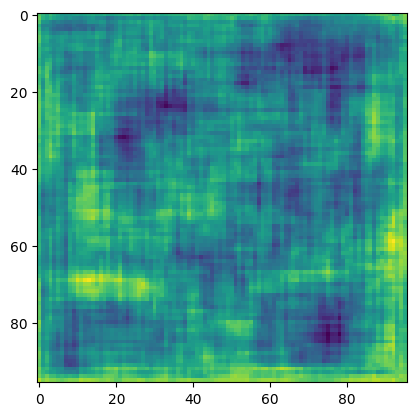

In [15]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_accuracy(real_output, fake_output):
    # Gerçek ve sahte çıkışları sigmoid aktivasyon fonksiyonuyla [0, 1] aralığına getirme
    real_predictions = tf.round(tf.sigmoid(real_output))
    fake_predictions = tf.round(tf.sigmoid(fake_output))

    # Doğruluk hesaplama
    correct_real_predictions = tf.equal(real_predictions, tf.ones_like(real_predictions))
    correct_fake_predictions = tf.equal(fake_predictions, tf.zeros_like(fake_predictions))

    # Toplam doğru tahmin sayısı
    total_correct = tf.reduce_sum(tf.cast(correct_real_predictions, tf.float32)) + tf.reduce_sum(tf.cast(correct_fake_predictions, tf.float32))

    # Toplam örnek sayısı
    total_samples = tf.cast(tf.size(real_output), tf.float32)

    # Doğruluk oranı
    accuracy = total_correct / total_samples

    return accuracy

generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

@tf.function
def train_step(images):
    seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(seed, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # Compute accuracy
        real_accuracy = discriminator_accuracy(tf.ones_like(real_output), real_output)
        fake_accuracy = discriminator_accuracy(tf.zeros_like(fake_output), fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy

def train(dataset, epochs):
    fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))
    start = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()

        gen_loss_list = []
        disc_loss_list = []
        real_accuracy_list = []
        fake_accuracy_list = []

        for image_batch in dataset:
            t = train_step(image_batch)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])
            real_accuracy_list.append(t[2])
            fake_accuracy_list.append(t[3])

        g_loss = sum(gen_loss_list) / len(gen_loss_list)
        d_loss = sum(disc_loss_list) / len(disc_loss_list)
        real_accuracy = sum(real_accuracy_list) / len(real_accuracy_list)
        fake_accuracy = sum(fake_accuracy_list) / len(fake_accuracy_list)

        epoch_elapsed = time.time() - epoch_start
        print(f'Epoch {epoch + 1}, gen loss={g_loss}, disc loss={d_loss}, real accuracy={real_accuracy}, fake accuracy={fake_accuracy}, {hms_string(epoch_elapsed)}')
        save_images(epoch, fixed_seed)

    elapsed = time.time() - start
    print(f'Training time: {hms_string(elapsed)}')

train(train_dataset, EPOCHS)